In [56]:
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
import xarray as xr
import random
from scipy.interpolate import LinearNDInterpolator
from itertools import product
from scipy.signal import savgol_filter
tqdm.pandas()
import math

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random

from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator
from regions import RectanglePixelRegion, PixCoord

%matplotlib inline

In [290]:
def filter_cygnss_df(df: pd.DataFrame, area: dict) -> pd.DataFrame:
    if 'sp_lat' in df.columns:
        new_df = df[df['sp_lat'] <= area['north']]
        new_df = new_df[new_df['sp_lat'] >= area['south']]
        new_df = new_df[new_df['sp_lon'] >= area['west']]
        new_df = new_df[new_df['sp_lon'] <= area['east']]
    else:
        new_df = df[df['lat'] <= area['north']]
        new_df = new_df[new_df['lat'] >= area['south']]
        new_df = new_df[new_df['long'] >= area['west']]
        new_df = new_df[new_df['long'] <= area['east']]

    return new_df


def filter_cygnss_day(df, start_day, end_day):
    filtered_df = df[df['day_of_year'] >= start_day]
    filtered_df = filtered_df[filtered_df['day_of_year'] < end_day]
    
    return filtered_df


def filter_smap_day(df, start_hour, end_hour):
    filtered_df = df[df['time'] >= start_hour]
    filtered_df = filtered_df[filtered_df['time'] < end_hour]
    return filtered_df


def calculate_correlation(sr_dict, sm_dict):
    trimmed_sr = []
    trimmed_sm = []
    
    for key in sm_dict.keys():
        trimmed_sr.append(sr_dict[key])
        trimmed_sm.append(sm_dict[key])
        
    return pd.Series(trimmed_sr).corr(pd.Series(trimmed_sm))


# Main time series for loop
def time_series_analysis(cygnss_df, smap_df, area, moving_window=2, interval=10, use_median=True, 
                         plot=True, area_name=None, save=None, error_bar_scale=10, 
                         print_missing_points=False):
    
    cygnss_df = filter_cygnss_df(cygnss_df, area)
    smap_df = filter_cygnss_df(smap_df, area)
    
    first_day = cygnss_df['day_of_year'].min()
    last_day = cygnss_df['day_of_year'].max()
    
    surface_ref = {}
    surface_ref_std = {}
    soil_moisture = {}
    soil_moisture_std = {}
    
    missing_sm_data_days = []
    
    for day in np.arange(first_day, last_day - moving_window, moving_window):
        # Filter CYGNSS
        current_cygnss = filter_cygnss_day(cygnss_df, day, day + interval)
        
        # Filter SMAP
        current_smap = filter_smap_day(smap_df, day*24, (day + interval)*24)
        
        if use_median:
            current_sr = current_cygnss['sr'].median()
            current_sr_std = current_cygnss['sr'].mad()
        else:
            current_sr = current_cygnss['sr'].mean()
            current_sr_std = current_cygnss['sr'].std()
        
        if len(current_smap) > 0:
            current_sm = current_smap['smap_sm'].mean()
            current_sm_std = current_smap['smap_sm'].std()
            soil_moisture[day] = current_sm
            soil_moisture_std[day] = current_sm_std
        else:
            # print('EMPTY SMAP from day:', day, 'to day:', day + interval)
            # current_sm = np.mean(list(soil_moisture.values()))
            # current_sm_std = 0
            missing_sm_data_days.append(day)
        
        surface_ref[day] = current_sr
        surface_ref_std[day] = current_sr_std
            
    if plot:
        
        error_bar_top = []
        error_bar_bottom = []
        
        for i in range(len(list(surface_ref.values()))):
            error_bar_top.append(list(surface_ref.values())[i] + list(surface_ref_std.values())[i]/error_bar_scale)
            error_bar_bottom.append(list(surface_ref.values())[i] - list(surface_ref_std.values())[i]/error_bar_scale)
        
        fig = plt.figure(figsize=(20, 6))
        ax = plt.axes()
        ax.grid()
        
        
        ax.plot(surface_ref.keys(), surface_ref.values(), color="red", marker="o", ls='none')
        ax.fill_between(surface_ref_std.keys(), error_bar_top, error_bar_bottom, alpha=.2, linewidth=0, color='red')
        label_size = 20
        ax.set_xlabel("Day after 1st of Jan 2019", fontsize=label_size)
        ax.set_ylabel("SR [dB]", color="red", fontsize=label_size)
        

        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(soil_moisture.keys(), soil_moisture.values(), color="blue", marker="o", ls='none')
        ax2.set_ylabel("SM [cm^3/cm^3]", color="blue", fontsize=label_size)
        ax.legend(['Surface Reflectivity (SR)', 'std SR/' + str(error_bar_scale)], loc=2)
        ax2.legend(['Soil Moisture (SM)'], loc=3)
        
        corr = calculate_correlation(surface_ref, soil_moisture)
        if area_name is not None:
            plt.title(area_name + " Correlation: " + str(round(corr, 3)), fontsize=22)
            if save is not None:
                plt.savefig('/Users/vegardhaneberg/Desktop/' + str(area_name) + '.svg')
        else:
            plt.title("Correlation: " + str(round(corr, 3)), fontsize=18)
            if save is not None:
                random_num = lambda: random.randint(0, 255)
                random_name = '%02X%02X%02X' % (random_num(), random_num(), random_num())
                plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/Without Name' + random_name + '.png', format='png')
        
        plt.show()
    
    if print_missing_points:
        print('Number of missing data points:', len(missing_sm_data_days))
        
    return surface_ref, surface_ref_std, soil_moisture, soil_moisture_std
    

def universal_plot(df, target_value='swvl1', title=None, bar_title=None, vmin=None, vmax=None, 
                   save=None, dot_size=0.5, std=False, fig_size=None, regions=None):
    
    if fig_size is not None:
        plt.rcParams["figure.figsize"] = fig_size
    else:
        plt.rcParams["figure.figsize"] = (8,8)
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lat_list, long_list = get_plot_ticks(df['lat'], df['long'])
    ax.set_xticks(long_list, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    if std:
        cmap = 'Greys'
    else:
        cmap = 'Spectral'
        
    if vmin is not None:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap)
    
    bar = plt.colorbar(shrink=0.8)
    if bar_title is not None:
        bar.ax.set_title(bar_title)
    
    if title is not None:
        plt.title(title, fontsize=20, fontweight='book')
    
    if regions is not None:
        
        regions[0].plot(ax=ax, color='black', lw=2.0)
        ax.annotate('Uniform soil', (regions[0].center.x + regions[0].width/2 + 0.2, regions[0].center.y),
                       fontsize=22,
                       color='black')
        regions[1].plot(ax=ax, color='blue', lw=2.0)
        ax.annotate('Variable soil', (regions[1].center.x, regions[1].center.y - regions[1].height/2 - 0.7),
                    fontsize=22,
                    color='blue',
                    horizontalalignment='center')
        
    plt.xlabel('Longitude', fontsize=16)
    plt.ylabel('Latitude', fontsize=16)
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

    plt.show()
    

def get_plot_ticks(lat_values, long_values):
    min_lat = min(lat_values)
    max_lat = max(lat_values)
    min_long = min(long_values)
    max_long = max(long_values)
    
    lat_step_size = (max_lat - min_lat) / 3
    long_step_size = (max_long - min_long) / 3
    
    long_list = [min_long, min_long + long_step_size, min_long + 2 * long_step_size, max_long]
    lat_list = [min_lat, min_lat + lat_step_size, min_lat + 2 * lat_step_size, max_lat]
    
    # Rounding to two decimals
    long_list = [round(num, 2) for num in long_list]
    lat_list = [round(num, 2) for num in lat_list]
    
    return lat_list, long_list



def get_coordinates(df):
    coordinates_df = df[(df['time'] > 48) & (df['time'] > 72)][['lat', 'long']].drop_duplicates()
    coords = []
    
    for index, row in coordinates_df.iterrows():
        coords.append((row.lat, row.long))
    return coords


def filter_smap_exact_coordinate(df, coordinate):
    return df[(df['lat'] == coordinate[0]) & (df['long'] == coordinate[1])]


def get_day_number_from_hours(hours):
    return math.floor(hours/24) + 1


def overall_time_series_plot_36_km(correlations, coordinates, selected_area, delta_x, delta_y,
                                       plot_correlations=False):
    special_regions = [max(correlations, key=correlations.get), min(correlations, key=correlations.get)]

    fig, ax = plt.subplots(figsize=(8, 8))

    plt.xlim([selected_area['west'] - 0.1, selected_area['east'] + 0.18])
    plt.ylim([selected_area['south'] - 0.1, selected_area['north'] + 0.2])

    # Scaling opacity values
    max_corr = max(list(correlations.values()))
    min_corr = min(list(correlations.values()))
    correlations_scaled = {}
    for key in correlations:
        correlations_scaled[key] = (correlations[key] - min_corr)/(max_corr - min_corr)

    # Main for loop
    for coord in coordinates:
        x = coord[1]
        y = coord[0]

        if (y, x) not in special_regions:
            not_scaled_corr = round(correlations[(y, x)], 2)
            current_corr = round(correlations_scaled[(y, x)], 2)
            rect = Rectangle((x - delta_x, y - delta_y), 2*delta_x, 2*delta_y, color='green', alpha=current_corr)
            ax.add_patch(rect)
            if plot_correlations:
                ax.text(x, y, not_scaled_corr, fontsize=8, verticalalignment='center', horizontalalignment='center')
        else:
            if correlations[(y, x)] == max_corr:
                rec_color = 'blue'
                alpha = 0.8
            else:
                rec_color = 'red'
                alpha = 1
            ax.add_patch(Rectangle((x - delta_x, y - delta_y), 2*delta_x, 2*delta_y, color=rec_color, alpha=alpha))


    plt.title(selected_area_string + ' Overview Correlation Between \nCYGNSS and SMAP for 2019 - 2021', fontsize=20)
    ax.set_xlabel('Longitude [degree]', fontsize=15)
    ax.set_ylabel('Latitude [degree]', fontsize=15)
    
    plt.savefig('/Users/vegardhaneberg/Desktop/overall_correlation.svg')

    plt.show()


  0% (0 of 203) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Done reading data. Starting time series loop...


100% (203 of 203) |######################| Elapsed Time: 0:06:29 Time:  0:06:29


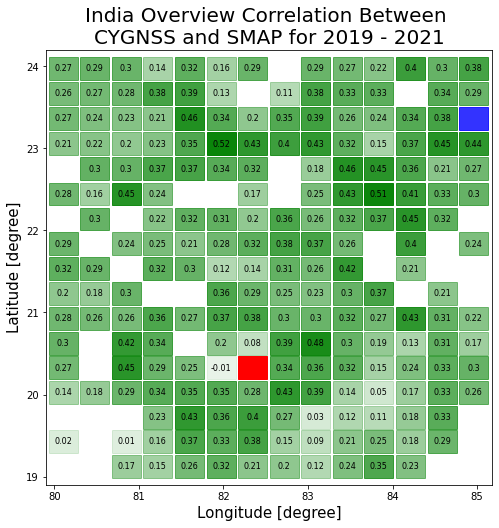

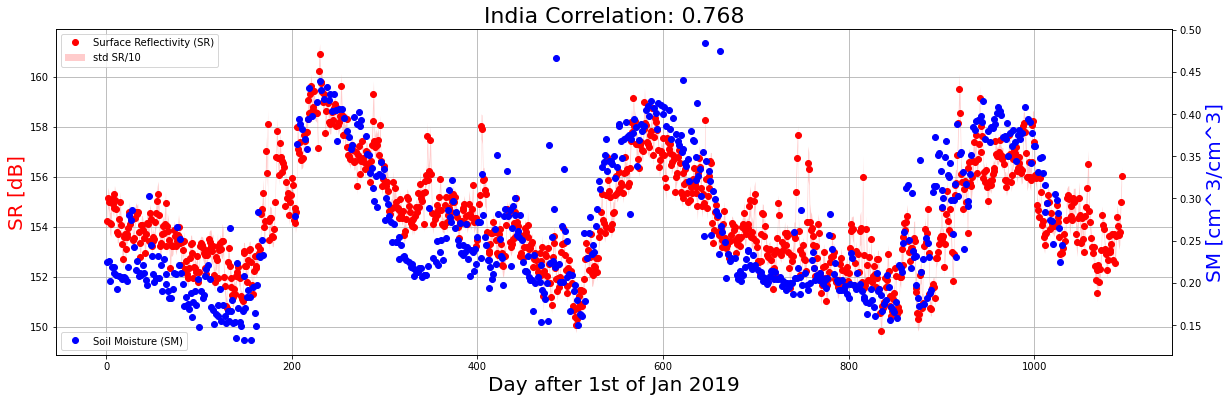

Best region center coordinate: (23.36277, 84.9585)


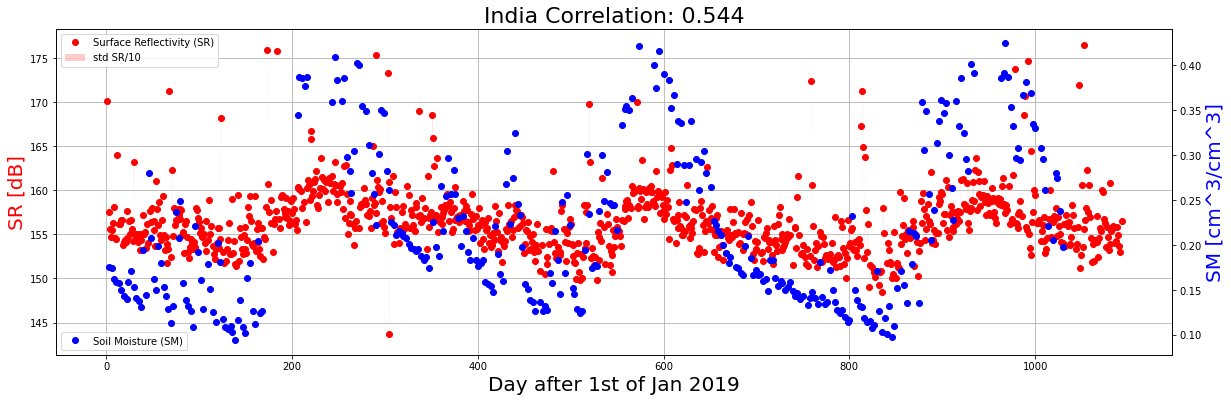

Worst region center coordinate: (20.325144, 82.3444)


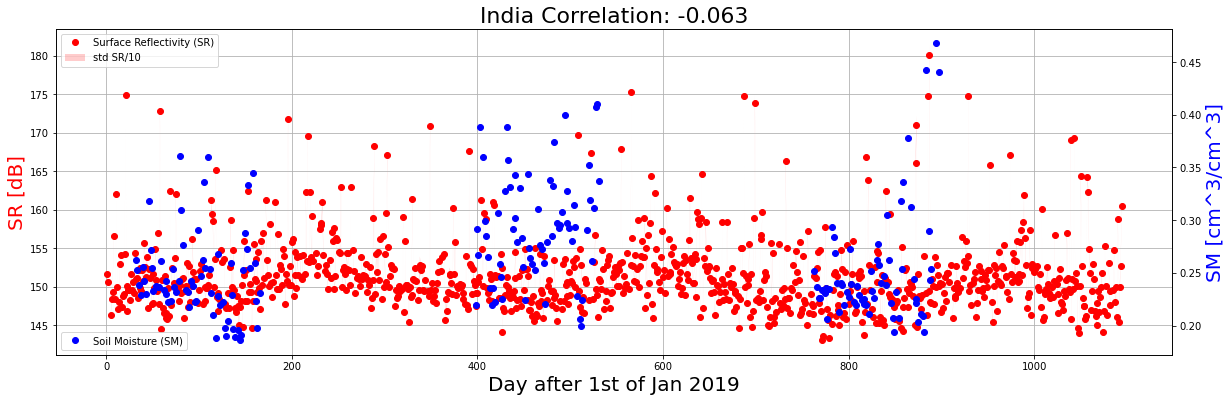

In [292]:
# 36x36km Main Time Series India
printing = False
filter_smap_qfs = True

selected_area_string = 'India'
selected_area = {'north': 24, 'south': 19, 'west': 80, 'east': 85}
selected_cygnss_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/24-80-19-85/CYGNSS 2019 to 2021'
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/36 km/India 2019-2021 v7.csv'

moving_window = 1  # Number of days to be skipped between each data point in the time series
interval = 1 # The number of days to be averaged in each data point in the time series
deltax = 0.18672 - 0.015
deltay = 0.154039 - 0.015

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)[['lat', 'long', 'time', 'smap_sm', 'retrieval_qfs']]

if filter_smap_qfs:
    raw_smap_df = raw_smap_df[raw_smap_df['retrieval_qfs'] == 8]
    
print('Done reading data. Starting time series loop...')

# Finding all unique coordinates
unique_coordinates = get_coordinates(raw_smap_df)

correlations = {}

for coord in progressbar(unique_coordinates):
    current_area = {'north': coord[0] + grid_box_delta, 
                    'south': coord[0] - grid_box_delta, 
                    'west': coord[1] - grid_box_delta, 
                    'east': coord[1] + grid_box_delta}
    current_area_string = 'Center coordinate: (' + str(round(coord[0], 2)) + ', ' + str(round(coord[1], 2)) + ')'
    
    current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
    current_smap = raw_smap_df[(round(raw_smap_df['lat'], 2) == round(coord[0], 2)) & (round(raw_smap_df['long'], 2) == round(coord[1], 2))]
    
    if printing:
        print('Starting time series for coordinate:', coord, '...\n')
        print('Length of cygnss df:', len(current_cygnss))
        print('Length of smap df:', len(current_smap))
    
    sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                   current_smap,
                                                   current_area,
                                                   moving_window,
                                                   interval,
                                                   True,
                                                   False,
                                                   current_area_string)
    
    correlations[(coord[0], coord[1])] = calculate_correlation(sr, sm)
    
    if printing:
        print('\n')

overall_time_series_plot_36_km(correlations, unique_coordinates, selected_area, deltax, deltay, True)

# Overall time series
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string)

# Time series best region
best_region_center = max(correlations, key=correlations.get)
print('Best region center coordinate:', best_region_center)
best_region = {'north': best_region_center[0] + grid_box_delta, 
               'south': best_region_center[0] - grid_box_delta, 
               'west': best_region_center[1] - grid_box_delta, 
               'east': best_region_center[1] + grid_box_delta}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, best_region), 
                                               filter_smap_exact_coordinate(raw_smap_df, best_region_center), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string)


# Time series worst region
worst_region_center = min(correlations, key=correlations.get)
print('Worst region center coordinate:', worst_region_center)
worst_region = {'north': worst_region_center[0] + grid_box_delta, 
                'south': worst_region_center[0] - grid_box_delta, 
                'west': worst_region_center[1] - grid_box_delta, 
                'east': worst_region_center[1] + grid_box_delta}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, worst_region), 
                                               filter_smap_exact_coordinate(raw_smap_df, worst_region_center), 
                                               worst_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string)



  0% (0 of 240) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Done reading data. Starting time series loop...


100% (240 of 240) |######################| Elapsed Time: 0:07:36 Time:  0:07:36


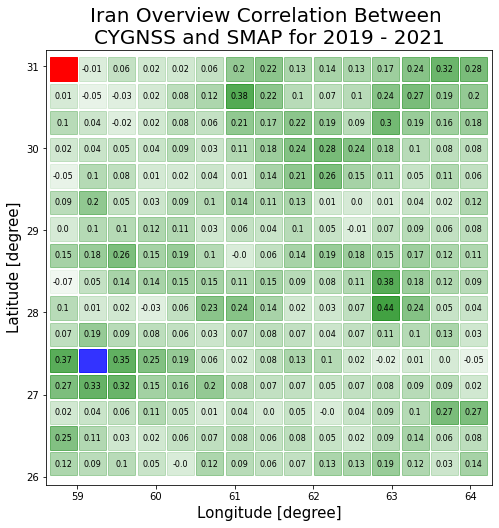

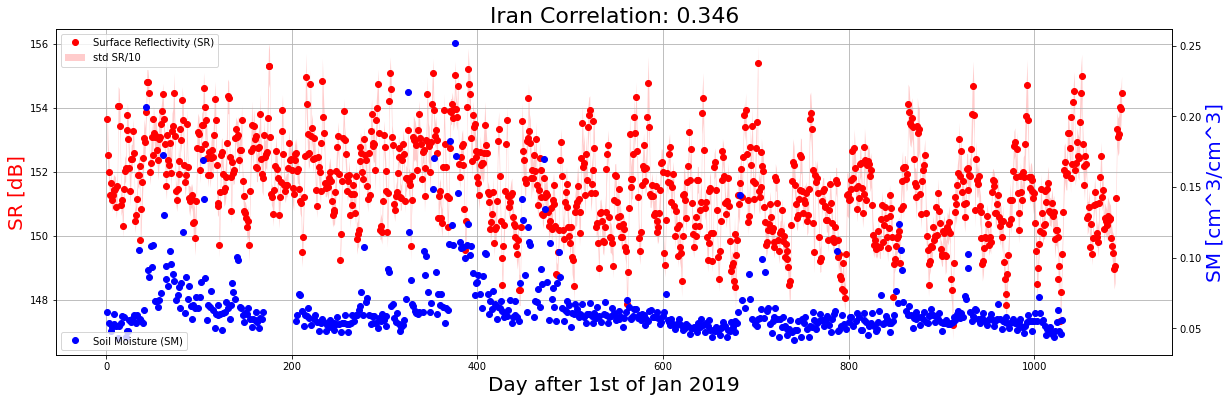

Best region center coordinate: (27.417961, 59.190872)


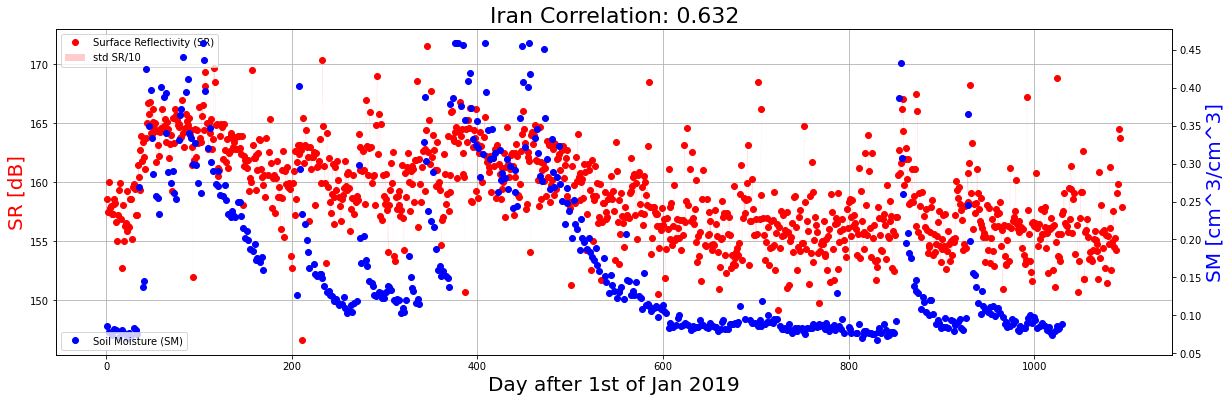

Worst region center coordinate: (30.966091, 58.81743)


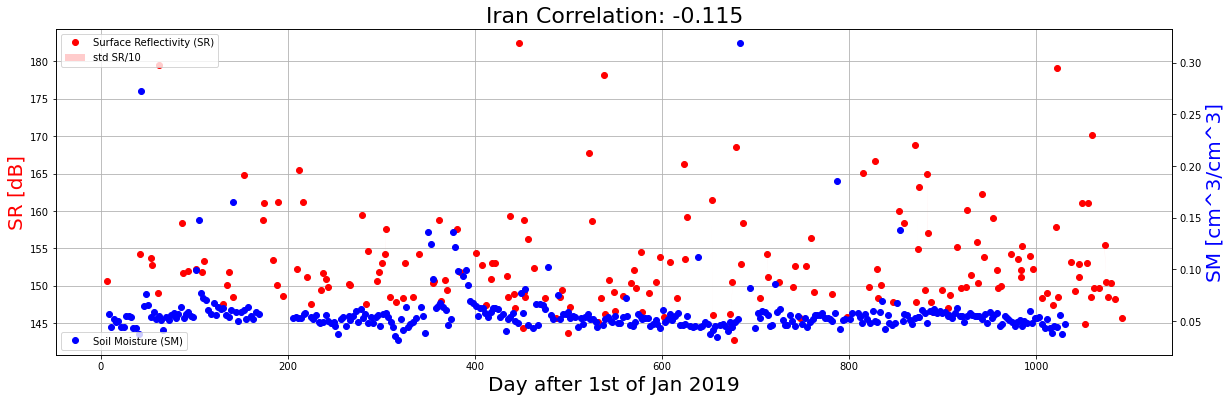

In [315]:
# 36x36km Main Time Series Iran
printing = False
filter_smap_qfs = False

selected_area_string = 'Iran'
selected_area = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
selected_cygnss_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/31-59-26-64/CYGNSS 2019 to 2021'
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 Years/36 km/Iran 2019-2021 v7.csv'

moving_window = 1   # Number of days to be skipped between each data point in the time series
interval = 1  # The number of days to be averaged in each data point in the time series
deltax = 0.186721 - 0.015  # TODO: Check this one
deltay = 0.1571315 - 0.015  # TODO: Check this one


raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)[['lat', 'long', 'time', 'smap_sm', 'retrieval_qfs']]

if filter_smap_qfs:
    raw_smap_df = raw_smap_df[raw_smap_df['retrieval_qfs'] == 8]
    
print('Done reading data. Starting time series loop...')

# Finding all unique coordinates
unique_coordinates = get_coordinates(raw_smap_df)

correlations = {}

for coord in progressbar(unique_coordinates):
    current_area = {'north': coord[0] + grid_box_delta, 
                    'south': coord[0] - grid_box_delta, 
                    'west': coord[1] - grid_box_delta, 
                    'east': coord[1] + grid_box_delta}
    current_area_string = 'Center coordinate: (' + str(round(coord[0], 2)) + ', ' + str(round(coord[1], 2)) + ')'
    
    current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
    current_smap = raw_smap_df[(round(raw_smap_df['lat'], 2) == round(coord[0], 2)) & (round(raw_smap_df['long'], 2) == round(coord[1], 2))]
    
    if printing:
        print('Starting time series for coordinate:', coord, '...\n')
        print('Length of cygnss df:', len(current_cygnss))
        print('Length of smap df:', len(current_smap))
    
    sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                   current_smap,
                                                   current_area,
                                                   moving_window,
                                                   interval,
                                                   True,
                                                   False,
                                                   current_area_string)
    
    correlations[(coord[0], coord[1])] = calculate_correlation(sr, sm)
    
    if printing:
        print('\n')

overall_time_series_plot_36_km(correlations, 
                               unique_coordinates, 
                               {'north': 31, 'south': 26, 'west': 58.7, 'east': 64.1}, 
                               deltax, 
                               deltay, 
                               True)

# Overall time series
sr, sr_std, sm, sm_std, = time_series_analysis(raw_cygnss_df, 
                                               raw_smap_df, 
                                               selected_area,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string)

# Time series best region
best_region_center = max(correlations, key=correlations.get)
print('Best region center coordinate:', best_region_center)
best_region = {'north': best_region_center[0] + grid_box_delta, 
               'south': best_region_center[0] - grid_box_delta, 
               'west': best_region_center[1] - grid_box_delta, 
               'east': best_region_center[1] + grid_box_delta}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, best_region), 
                                               filter_smap_exact_coordinate(raw_smap_df, best_region_center), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string)


# Time series worst region
worst_region_center = min(correlations, key=correlations.get)
print('Worst region center coordinate:', worst_region_center)
worst_region = {'north': worst_region_center[0] + grid_box_delta, 
                'south': worst_region_center[0] - grid_box_delta, 
                'west': worst_region_center[1] - grid_box_delta, 
                'east': worst_region_center[1] + grid_box_delta}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, worst_region), 
                                               filter_smap_exact_coordinate(raw_smap_df, worst_region_center), 
                                               worst_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               selected_area_string)

